## The Binomial Paths Averaging Method for Options Pricing as a Function of Volatility

When we have a stochastic model, we simulate an appropriate number of paths, then take the average of the payoff before discounting to the present value to obtain the price of a European option. This is true whether we are modeling the underlying asset price's evolution as a Geometric Brownian Motion, or using a Heston or a Merton model. For the Binomial or Trinomial models, the method is a little different; in these models, at each beginning or intermediate node, we average over the weighted payoffs at each nodes that is a child to that node. But what happens when we treat all Binomial paths as if they were stochastic use compute the option price as if we were doing a Monte Carlo computation? As we explored in a previous work, the prices are way off using this naive method - when compared to the Black-Scholes benchmark. We attributed that to the fact that the Binomial distributions are not fat-tailed, and we modified the distributions by reducing and increasing frequencies linearly as we move out the center of the distribution towards the tail. This strategy is captured by multiplying the frequencies with the kernel function $K_\alpha(r) = \alpha\left(\left\lvert\frac{8.2r}{M}-4.1\right\rvert+0.9\right)$, with $\alpha$ chosen to match the Black-Scholes prices. There, we considered various number of "Bernoulli trials" $M$, and we saw good use. The choice of 8.2, 4.1, and 0.9 are based on the fact that we aim at removing about $10\%$ from the mode frequency, and adding about four time more frequency to the tips of the distribution. These choices are, of course, arbitrary, and research can also be done in identifying if there is an optimal combination of these numbers, but this is not the focus of this exploration.

In this work, we fix a choiced $M$, which is arbitrary, and we seek to model $\alpha$ as a function or as functions of volatility $\sigma$. We will see that accuracy is obtained when we consider put and call options separately. The purpose of these functions is to approximate the $\alpha$ values of any given volatility, and to interpolate the option price. We will see that this method works well to five decimal places of accuracy for the test volatility values $\sigma$, which are up to three decimal places in variation. All these ideas will be made clear and precise in the work proper below.

This method will be referred to as the **X-Method** when needed. We will also see that the time complexity of the X-Method is linear in $M$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import numpy.random as npr
from scipy.stats import norm
import multiprocessing as mp
import math
from scipy.optimize import minimize
import scipy.stats as stats
import statsmodels.api as sm
from scipy.optimize import curve_fit
from scipy.interpolate import make_interp_spline
from scipy.interpolate import UnivariateSpline

We will use the following parameters for demonstration throughout.

In [2]:
## The parameters we will be using
S_ini, K, T, rf, M = 100, 100, 0.25, 0.05, 60
Ite = 2**M
np.random.seed=23

### Black-Scholes Model

In [3]:
# European Black-Scholes
def bs_pricing(S, K, T, r, sigma, t, opttype):
    ttm = T - t  # Time to maturity

    if ttm < 0:
        return 0.0
    elif ttm == 0.0:
        if opttype == "c":
            return np.maximum(S - K, 0.0)
        elif opttype == "p":
            return np.maximum(K - S, 0.0)
        else:
            raise ValueError("Invalid option type. Use 'c' for call or 'p' for put.")

    vol = sigma * np.sqrt(ttm)
    d_minus = (np.log(S / K) + (r - 0.5 * sigma**2) * ttm) / vol
    d_plus = d_minus + vol

    if opttype == "c":
        return S * norm.cdf(d_plus) - K * np.exp(-r * ttm) * norm.cdf(d_minus)
    elif opttype == "p":
        return K * np.exp(-r * ttm) * norm.cdf(-d_minus) - S * norm.cdf(-d_plus)
    else:
        raise ValueError("Invalid option type. Use 'c' for call or 'p' for put.")

In [4]:
sigma = [0.01*n for n in range(1, 100)]

In [5]:
bs_price_list = []
for vol in sigma:
    call = bs_pricing(S_ini, K, T, rf, vol, 0, 'c')
    put = bs_pricing(S_ini, K, T, rf, vol, 0, 'p')
    bs_price_list.append({
        r"$\sigma$": float(vol),
        "BS Call": call,
        "BS Put": put
    })

bs_price_list = pd.DataFrame(bs_price_list)

In [6]:
bs_price_list.T

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
$\sigma$,0.010000,0.020000,0.030000,0.040000,0.050000,0.060000,0.070000,0.080000,0.090000,0.100000,...,0.900000,0.910000,0.920000,0.930000,0.94000,0.950000,0.960000,0.970000,0.980000,0.990000
BS Call,1.243216,1.292491,1.411116,1.564034,1.733611,1.912223,2.096217,2.283656,2.473422,2.664832,...,18.319323,18.512468,18.705505,18.898433,19.09125,19.283955,19.476548,19.669026,19.861389,20.053635
BS Put,0.000996,0.050271,0.168896,0.321814,0.491391,0.670003,0.853998,1.041436,1.231202,1.422612,...,17.077103,17.270248,17.463285,17.656213,17.84903,18.041735,18.234328,18.426806,18.619169,18.811415


### The Binomial Pricing Method

In [7]:
def binomial_call_full(S_ini, K, T, r, vol, N):
    dt = T / N  # Define time step
    u = np.exp(vol * np.sqrt(dt))  # Define u
    d = np.exp(-vol * np.sqrt(dt))  # Define d
    p = (np.exp(r * dt) - d) / (u - d)  # Risk neutral probs
    C = np.zeros([N + 1, N + 1])  # Call prices
    S = np.zeros([N + 1, N + 1])  # Underlying price
    for i in range(0, N + 1):
        C[N, i] = max(S_ini * (u ** (i)) * (d ** (N - i)) - K, 0)
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            C[j, i] = np.exp(-r * dt) * (p * C[j + 1, i + 1] + (1 - p) * C[j + 1, i])
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
    return C[0, 0], C, S

def binomial_put_full(S_ini, K, T, r, vol, N):
    dt = T / N  # Define time step
    u = np.exp(vol * np.sqrt(dt))  # Define u
    d = np.exp(-vol * np.sqrt(dt))  # Define d
    p = (np.exp(r * dt) - d) / (u - d)  # Risk neutral probs
    P = np.zeros([N + 1, N + 1])  # Call prices
    S = np.zeros([N + 1, N + 1])  # Underlying price
    for i in range(0, N + 1):
        P[N, i] = max(K - (S_ini * (u ** (i)) * (d ** (N - i))), 0)
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            P[j, i] = np.exp(-r * dt) * (p * P[j + 1, i + 1] + (1 - p) * P[j + 1, i])
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
    return P[0, 0], P, S

In [8]:
binomial_price_list = []
for vol in sigma:
    bin_call = binomial_call_full(S_ini, K, T, rf, vol, M)[0]
    bin_put = binomial_put_full(S_ini, K, T, rf, vol, M)[0]
    binomial_price_list.append({
        r"$\sigma$": vol,
        "Binomial Call": bin_call,
        "Binomial Put": bin_put
    })

binomial_price_list = pd.DataFrame(binomial_price_list)

In [9]:
binomial_price_list.T

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
$\sigma$,0.010000,0.020000,0.030000,0.040000,0.050000,0.060000,0.070000,0.080000,0.090000,0.100000,...,0.900000,0.910000,0.92000,0.930000,0.940000,0.950000,0.96000,0.970000,0.980000,0.990000
Binomial Call,1.242971,1.290562,1.408156,1.560262,1.729065,1.906902,2.090115,2.276764,2.465735,2.656346,...,18.245751,18.438094,18.63033,18.822456,19.014472,19.206377,19.39817,19.589849,19.781413,19.972861
Binomial Put,0.000751,0.048342,0.165936,0.318043,0.486845,0.664682,0.847895,1.034544,1.223515,1.414126,...,17.003531,17.195874,17.38811,17.580236,17.772252,17.964157,18.15595,18.347629,18.539193,18.730641


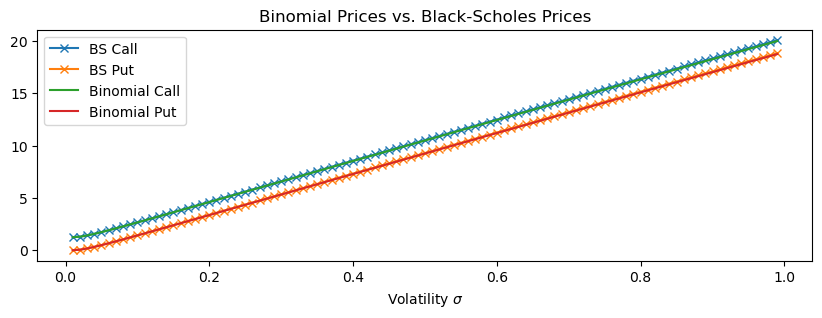

In [10]:
# Set the figure size
plt.figure(figsize=(10, 3))

plt.plot(bs_price_list[r"$\sigma$"], bs_price_list["BS Call"], label="BS Call", marker="x")
plt.plot(bs_price_list[r"$\sigma$"], bs_price_list["BS Put"], label="BS Put", marker="x")
plt.plot(bs_price_list[r"$\sigma$"], binomial_price_list["Binomial Call"], label="Binomial Call")
plt.plot(bs_price_list[r"$\sigma$"], binomial_price_list["Binomial Put"], label="Binomial Put")

plt.xlabel(r"Volatility $\sigma$")
plt.ylabel("")
plt.title("Binomial Prices vs. Black-Scholes Prices")

plt.legend()

plt.show()

From the plot, it does appear that the binomial and Black-Scholes prices coincide perfectly for most practical purposes. This is indeed a theoretical fact. As such, we will use the Black-Scholes values for our subsequent computations and comparisons.

### Computing and Using the Optimal $\alpha$s.

We now compute the optimal $\alpha$s by minimizing the errors with Black-Scholes prices.

In [11]:
price_dist_coll = []
for vol in sigma:
    price_dist = []
    for r in range(0, M+1):
        dt = T/M
        u = np.exp(vol * np.sqrt(dt))
        d = 1/u
        p = (np.exp(rf * dt) - d) / (u - d)
        q = 1-p
        price = float(S_ini*(u**r)*(d**(M-r)))
        freq = math.comb(M, r)
        price_dist.append({
            "r": int(r),
            "End Price": price,
            "Frequency": freq
        })
    price_dist = pd.DataFrame(price_dist)
    price_dist_coll = price_dist_coll+[price_dist]

In [12]:
price_dist_coll[-1].T

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
r,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000e+00,6.000000e+00,7.000000e+00,8.000000e+00,9.000000e+00,...,5.100000e+01,5.200000e+01,5.300000e+01,5.400000e+01,5.500000e+01,56.000000,57.000000,58.000000,59.000000,60.000000
End Price,2.161747,2.456469,2.791373,3.171936,3.604383,4.095787e+00,4.654188e+00,5.288718e+00,6.009757e+00,6.829099e+00,...,1.464322e+03,1.663961e+03,1.890817e+03,2.148603e+03,2.441533e+03,2774.400306,3152.649053,3582.466461,4070.883163,4625.888311
Frequency,1.000000,60.000000,1770.000000,34220.000000,487635.000000,5.461512e+06,5.006386e+07,3.862069e+08,2.558621e+09,1.478314e+10,...,1.478314e+10,2.558621e+09,3.862069e+08,5.006386e+07,5.461512e+06,487635.000000,34220.000000,1770.000000,60.000000,1.000000


A few trials runs revealed that the factor $\alpha$ in the kernel $K_\alpha(r) = \alpha\left(\left\lvert\frac{8.2r}{M}-4.1\right\rvert+0.9\right)$ tends to $0$, making the optimization process to obtain $\alpha$ very sensitive and unreliable. So, instead of optimizing to obtain $\alpha$, we perform an optimization to obtain a raised value of the factor. Raising by 2 units appears to work well (1 works well with $\alpha$s for call options, but not so for the $\alpha$ associated with put options at $\sigma=0.01$). As such, the kernel now assumes the form
\begin{equation}
K_\alpha(r) = (\alpha-2)\left(\left\lvert\frac{8.2r}{M}-4.1\right\rvert+0.9\right).
\end{equation}

In [13]:
def kernel(alpha, x, M):
    return (alpha-2)*abs((8.2*x/M)-4.1)+0.9
    ## We compute for the values of alpha+1 instead because the factor itself approachs 0, making computation very sensitive and inaccurate

def erf_c(alpha):
        df = price_dist_coll[n]
        df["Adjusted Freq."] = df["Frequency"]*(kernel(alpha, df["r"], 60))
        terms_c = []
        for r in range(0, M+1):
            term_c = (max(df['End Price'][r]-K, 0))*(df['Adjusted Freq.'][r])
            terms_c = terms_c+[term_c]
        sum_mod_price_c = sum(terms_c)
        call_price = np.exp(-rf*T)*(sum_mod_price_c/2**M)
        bs_call_price = (bs_price_list.loc[bs_price_list[r"$\sigma$"] == sigma[n], "BS Call"]).iloc[0] #This is the Black-Scholes call price that has been computed above.
        return float(abs(call_price-bs_call_price))

def erf_p(alpha):
        df = price_dist_coll[n]
        df["Adjusted Freq."] = df["Frequency"]*(kernel(alpha, df["r"], 60))
        terms_p = []
        for r in range(0, M+1):
            term_p = (max(K-df['End Price'][r], 0))*(df['Adjusted Freq.'][r])
            terms_p = terms_p+[term_p]
        sum_mod_price_p = sum(terms_p)
        put_price = np.exp(-rf*T)*(sum_mod_price_p/2**M)
        bs_put_price = (bs_price_list.loc[bs_price_list[r"$\sigma$"] == sigma[n], "BS Put"]).iloc[0]
        return float(abs(put_price-bs_put_price))

In [14]:
Opt_Val_c = []
for n in range(0, 99):
    constraints = ({'type': 'ineq', 'fun': lambda x: x[0]})
    res_c = minimize(erf_c, 1, constraints=constraints)
    Opt_Val_c.append({
        r"$\sigma$": sigma[n],
        r"Opt. Call $\alpha$": float(res_c['x'][0])
    })

Opt_Val_c = pd.DataFrame(Opt_Val_c)
Opt_Val_c.T

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
$\sigma$,0.010000,0.020000,0.030000,0.040000,0.050000,0.060000,0.07000,0.080000,0.09000,0.100000,...,0.900000,0.910000,0.920000,0.930000,0.940000,0.95000,0.960000,0.970000,0.980000,0.990000
Opt. Call $\alpha$,10.125535,5.557117,4.208873,3.598104,3.255255,3.036628,2.88499,2.773369,2.68748,2.619084,...,1.804526,1.800117,1.795735,1.791381,1.787052,1.78275,1.778473,1.774221,1.769995,1.765793


In [15]:
Opt_Val_p = []
for n in range(0, 99):
    constraints = ({'type': 'ineq', 'fun': lambda x: x[0]})
    res_p = minimize(erf_p, 1, constraints=constraints)
    Opt_Val_p.append({
        r"$\sigma$": sigma[n],
        r"Opt. Put $\alpha$": float(res_p['x'][0])
    })

Opt_Val_p = pd.DataFrame(Opt_Val_p)
Opt_Val_p.T

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
$\sigma$,0.010000,0.020000,0.030000,0.040000,0.050000,0.060000,0.070000,0.080000,0.090000,0.10000,...,0.900000,0.910000,0.920000,0.930000,0.940000,0.950000,0.960000,0.970000,0.980000,0.990000
Opt. Put $\alpha$,0.655505,0.840612,1.081579,1.269974,1.410449,1.517269,1.600874,1.668125,1.723529,1.77012,...,2.564824,2.570848,2.576862,2.582867,2.588864,2.594853,2.600834,2.606808,2.612774,2.618733


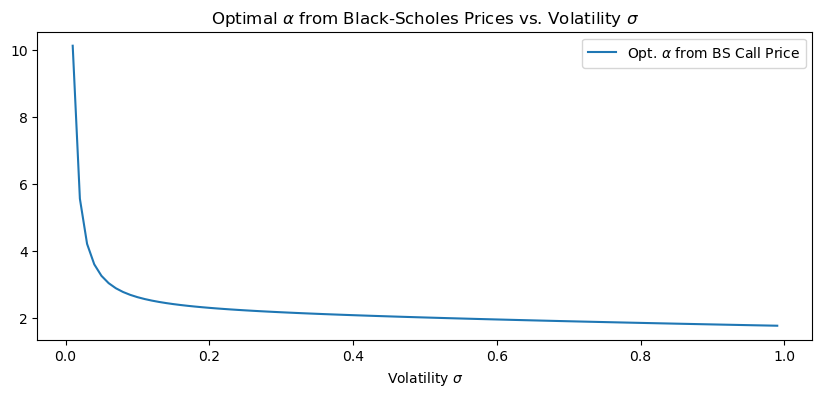

In [16]:
# Set the figure size
plt.figure(figsize=(10, 4))

plt.plot(Opt_Val_c[r"$\sigma$"], Opt_Val_c[r"Opt. Call $\alpha$"], label=r"Opt. $\alpha$ from BS Call Price")

plt.xlabel(r"Volatility $\sigma$")
plt.ylabel("")
plt.title(r"Optimal $\alpha$ from Black-Scholes Prices vs. Volatility $\sigma$")

plt.legend()

plt.show()

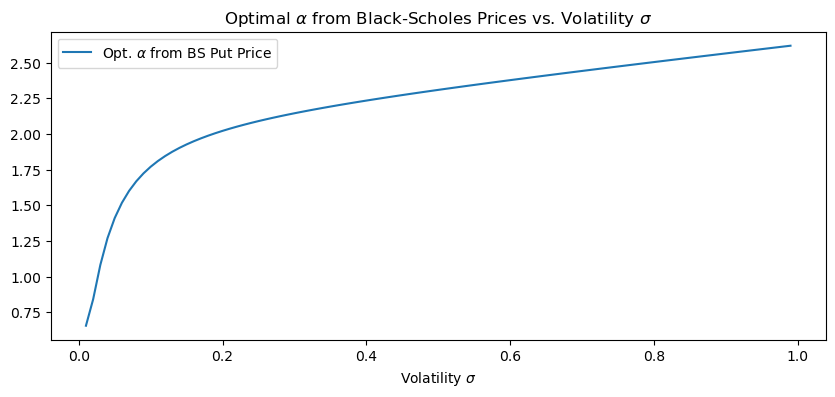

In [17]:
# Set the figure size
plt.figure(figsize=(10, 4))

plt.plot(Opt_Val_p[r"$\sigma$"], Opt_Val_p[r"Opt. Put $\alpha$"], label=r"Opt. $\alpha$ from BS Put Price")

plt.xlabel(r"Volatility $\sigma$")
plt.ylabel("")
plt.title(r"Optimal $\alpha$ from Black-Scholes Prices vs. Volatility $\sigma$")

plt.legend()

plt.show()

The two curve above reveal smooth spline rendering of the $\alpha$ values. It is to be noted that before the optimization of a raised value of the factor, the curves appeared unreliable for values close to 1 for $\alpha$s associated with the call option, and values close to 0 for the $\alpha$s associated with the put option. We now derive the spline approximation to the functional form of these $\alpha$s given volatility $\sigma$, then use them to compare prices.

First, $\alpha$s associated with call options.

In [18]:
# Extract σ and α from your data
sigma_call = Opt_Val_c[r"$\sigma$"]
alpha_call = Opt_Val_c[r"Opt. Call $\alpha$"]

# Fit a spline (you can choose the smoothness `s`)
spline_call = UnivariateSpline(sigma_call, alpha_call, s=0)

In [19]:
pred_call_alphas = []
for n in range(0, 99):
    pred_alpha = spline_call(sigma[n])
    pred_call_alphas.append({
        r"$\sigma$": sigma[n],
        r"Pred. $\alpha$ (Call)": pred_alpha,
        r"Actual $\alpha$ (Call)": Opt_Val_c.loc[Opt_Val_c[r"$\sigma$"] == sigma[n], r"Opt. Call $\alpha$"].iloc[0]
    })

pred_call_alphas = pd.DataFrame(pred_call_alphas)
pred_call_alphas.T

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
$\sigma$,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,...,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
Pred. $\alpha$ (Call),10.125535384906991,5.557117124221169,4.208872685200932,3.598103739534559,3.2552552390744958,3.0366283851120888,2.8849902994036634,2.7733689577691676,2.6874803715034195,2.61908357865733,...,1.8045259525025577,1.8001171236822386,1.7957354484009713,1.7913805285901327,1.7870519959912587,1.7827495157168984,1.778472727938251,1.7742213908337938,1.7699951762336101,1.7657933446592184
Actual $\alpha$ (Call),10.125535,5.557117,4.208873,3.598104,3.255255,3.036628,2.88499,2.773369,2.68748,2.619084,...,1.804526,1.800117,1.795735,1.791381,1.787052,1.78275,1.778473,1.774221,1.769995,1.765793


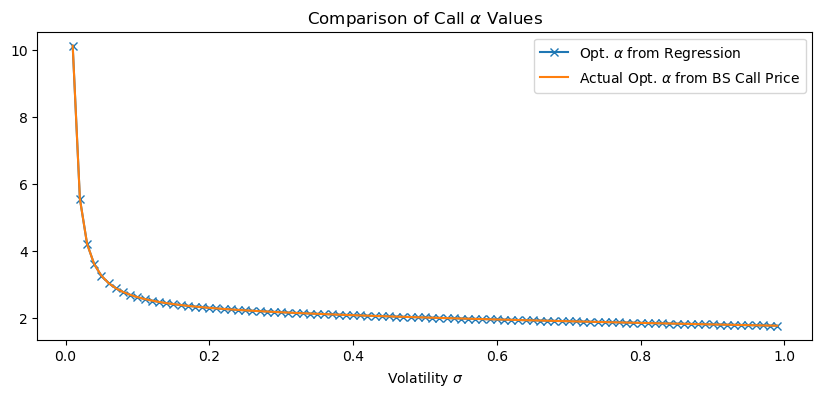

In [20]:
# Set the figure size
plt.figure(figsize=(10, 4))

plt.plot(pred_call_alphas[r"$\sigma$"], pred_call_alphas[r"Pred. $\alpha$ (Call)"], label=r"Opt. $\alpha$ from Regression", marker='x')
plt.plot(pred_call_alphas[r"$\sigma$"], pred_call_alphas[r"Actual $\alpha$ (Call)"], label=r"Actual Opt. $\alpha$ from BS Call Price")

plt.xlabel(r"Volatility $\sigma$")
plt.ylabel("")
plt.title(r"Comparison of Call $\alpha$ Values")

plt.legend()

plt.show()

In [21]:
tuned_prices_rg_c = []
for n in range(0, 99):
    df = price_dist_coll[n]
    df["Adjusted Freq. C"] = df["Frequency"]*(kernel((pred_call_alphas.loc[pred_call_alphas[r"$\sigma$"]==sigma[n], r"Pred. $\alpha$ (Call)"]).iloc[0], df["r"], 60))
    terms_c = []
    for r in range(0, M+1):
        term_c = (max(df['End Price'][r]-K, 0))*(df['Adjusted Freq. C'][r])
        terms_c = terms_c+[term_c]
    sum_mod_price_c = sum(terms_c)
    call_price = np.exp(-rf*T)*(sum_mod_price_c/2**M)
    bs_call_price = (bs_price_list.loc[bs_price_list[r"$\sigma$"] == sigma[n], "BS Call"]).iloc[0]
    
    tuned_prices_rg_c.append({
        r"$\sigma$": sigma[n],
        "Call Price": float(call_price),
        "BS Call": float(bs_price_list.loc[bs_price_list[r"$\sigma$"] == sigma[n], "BS Call"].iloc[0]),
        "Diff. (Call)": float(abs(call_price-bs_call_price))
    })

tuned_prices_rg_c = pd.DataFrame(tuned_prices_rg_c)
tuned_prices_rg_c.T

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
$\sigma$,1.000000e-02,2.000000e-02,3.000000e-02,4.000000e-02,5.000000e-02,6.000000e-02,7.000000e-02,8.000000e-02,9.000000e-02,1.000000e-01,...,9.000000e-01,9.100000e-01,9.200000e-01,9.300000e-01,9.400000e-01,9.500000e-01,9.600000e-01,9.700000e-01,9.800000e-01,0.990000
Call Price,1.243216e+00,1.292491e+00,1.411116e+00,1.564034e+00,1.733611e+00,1.912223e+00,2.096217e+00,2.283656e+00,2.473422e+00,2.664832e+00,...,1.831932e+01,1.851247e+01,1.870551e+01,1.889843e+01,1.909125e+01,1.928396e+01,1.947655e+01,1.966903e+01,1.986139e+01,20.053628
BS Call,1.243216e+00,1.292491e+00,1.411116e+00,1.564034e+00,1.733611e+00,1.912223e+00,2.096217e+00,2.283656e+00,2.473422e+00,2.664832e+00,...,1.831932e+01,1.851247e+01,1.870551e+01,1.889843e+01,1.909125e+01,1.928396e+01,1.947655e+01,1.966903e+01,1.986139e+01,20.053635
Diff. (Call),2.743221e-07,9.816528e-08,9.223545e-08,4.875527e-08,4.799743e-09,2.734539e-08,6.590239e-11,5.760196e-08,2.996925e-08,7.829697e-08,...,6.601500e-07,3.744096e-07,1.545430e-12,1.895785e-07,1.270220e-07,5.404004e-08,5.577897e-07,2.606437e-07,4.889602e-07,0.000007


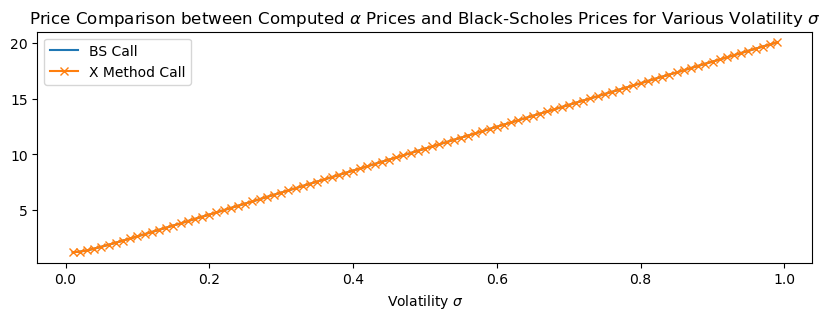

In [22]:
# Set the figure size
plt.figure(figsize=(10, 3))

plt.plot(tuned_prices_rg_c[r"$\sigma$"], bs_price_list["BS Call"], label="BS Call")
plt.plot(tuned_prices_rg_c[r"$\sigma$"], tuned_prices_rg_c["Call Price"], label="X Method Call", marker='x')

plt.xlabel(r"Volatility $\sigma$")
plt.ylabel("")
plt.title(r"Price Comparison between Computed $\alpha$ Prices and Black-Scholes Prices for Various Volatility $\sigma$")

plt.legend()

plt.show()

Next, $\alpha$s associated with put options.

In [23]:
# Extract σ and α from your data
sigma_put = Opt_Val_p[r"$\sigma$"]
alpha_put = Opt_Val_p[r"Opt. Put $\alpha$"]

# Fit a spline (you can choose the smoothness `s`)
spline_put = UnivariateSpline(sigma_put, alpha_put, s=0)

In [24]:
pred_put_alphas = []
for n in range(0, 99):
    pred_alpha = spline_put(sigma[n])
    pred_put_alphas.append({
        r"$\sigma$": sigma[n],
        r"Pred. $\alpha$ (Put)": pred_alpha,
        r"Actual $\alpha$ (Put)": Opt_Val_p.loc[Opt_Val_p[r"$\sigma$"] == sigma[n], r"Opt. Put $\alpha$"].iloc[0]
    })

pred_put_alphas = pd.DataFrame(pred_put_alphas)
pred_put_alphas.T

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
$\sigma$,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,...,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
Pred. $\alpha$ (Put),0.6555052636591847,0.8406124060934795,1.0815792054372084,1.26997424876162,1.4104493377307787,1.5172686876106867,1.6008742844755028,1.6681248444137844,1.7235288573600729,1.7701200463108313,...,2.5648243121647614,2.570847505828024,2.576861671392434,2.5828671265977614,2.5888641790945215,2.594853110464511,2.6008342045981534,2.606807736149848,2.6127738986562794,2.618732834767251
Actual $\alpha$ (Put),0.655505,0.840612,1.081579,1.269974,1.410449,1.517269,1.600874,1.668125,1.723529,1.77012,...,2.564824,2.570848,2.576862,2.582867,2.588864,2.594853,2.600834,2.606808,2.612774,2.618733


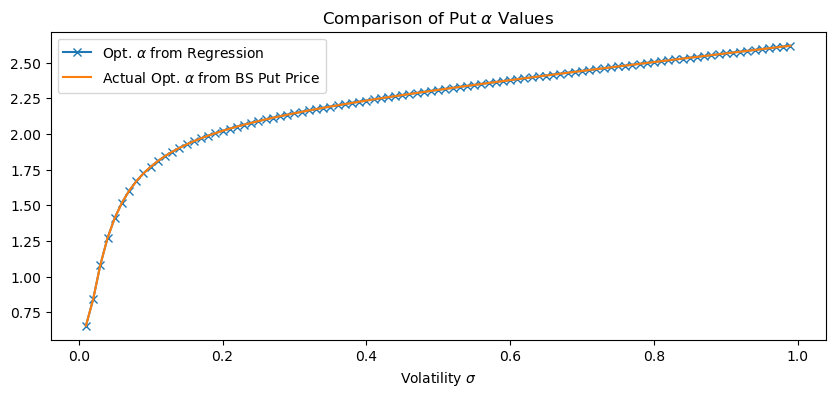

In [25]:
# Set the figure size
plt.figure(figsize=(10, 4))

plt.plot(pred_put_alphas[r"$\sigma$"], pred_put_alphas[r"Pred. $\alpha$ (Put)"], label=r"Opt. $\alpha$ from Regression", marker='x')
plt.plot(pred_put_alphas[r"$\sigma$"], pred_put_alphas[r"Actual $\alpha$ (Put)"], label=r"Actual Opt. $\alpha$ from BS Put Price")

plt.xlabel(r"Volatility $\sigma$")
plt.ylabel("")
plt.title(r"Comparison of Put $\alpha$ Values")

plt.legend()

plt.show()

In [26]:
tuned_prices_rg_p = []
for n in range(0, 99):
    df = price_dist_coll[n]
    df["Adjusted Freq. P"] = df["Frequency"]*(kernel((pred_put_alphas.loc[pred_put_alphas[r"$\sigma$"]==sigma[n], r"Pred. $\alpha$ (Put)"]).iloc[0], df["r"], 60))
    terms_p = []
    for r in range(0, M+1):
        term_p = (max(K-df['End Price'][r], 0))*(df['Adjusted Freq. P'][r])
        terms_p = terms_p+[term_p]
    sum_mod_price_p = sum(terms_p)
    put_price = np.exp(-rf*T)*(sum_mod_price_p/2**M)
    bs_put_price = (bs_price_list.loc[bs_price_list[r"$\sigma$"] == sigma[n], "BS Put"]).iloc[0]
    
    tuned_prices_rg_p.append({
        r"$\sigma$": sigma[n],
        "Put Price": float(put_price),
        "BS Put": float(bs_price_list.loc[bs_price_list[r"$\sigma$"] == sigma[n], "BS Put"].iloc[0]),
        "Diff. (Put)": float(abs(put_price-bs_put_price))
    })

tuned_prices_rg_p = pd.DataFrame(tuned_prices_rg_p)
tuned_prices_rg_p.T

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
$\sigma$,1.000000e-02,2.000000e-02,3.000000e-02,4.000000e-02,5.000000e-02,6.000000e-02,7.000000e-02,8.000000e-02,9.000000e-02,1.000000e-01,...,9.000000e-01,9.100000e-01,9.200000e-01,9.300000e-01,9.400000e-01,9.500000e-01,9.600000e-01,9.700000e-01,9.800000e-01,0.990000
Put Price,9.958234e-04,5.027125e-02,1.688956e-01,3.218136e-01,4.913909e-01,6.700033e-01,8.539975e-01,1.041436e+00,1.231203e+00,1.422613e+00,...,1.707710e+01,1.727025e+01,1.746329e+01,1.765621e+01,1.784903e+01,1.804174e+01,1.823433e+01,1.842681e+01,1.861917e+01,18.811414
BS Put,9.958226e-04,5.027126e-02,1.688956e-01,3.218136e-01,4.913909e-01,6.700033e-01,8.539975e-01,1.041436e+00,1.231202e+00,1.422612e+00,...,1.707710e+01,1.727025e+01,1.746329e+01,1.765621e+01,1.784903e+01,1.804174e+01,1.823433e+01,1.842681e+01,1.861917e+01,18.811415
Diff. (Put),8.340875e-10,3.515791e-09,9.041795e-10,3.870339e-08,3.086447e-10,3.827859e-08,1.172297e-10,3.056197e-09,2.913732e-07,8.903962e-07,...,3.679936e-08,1.015572e-08,7.997951e-09,2.988791e-10,5.340723e-10,4.701156e-08,5.164222e-08,1.220115e-07,9.620038e-11,0.000001


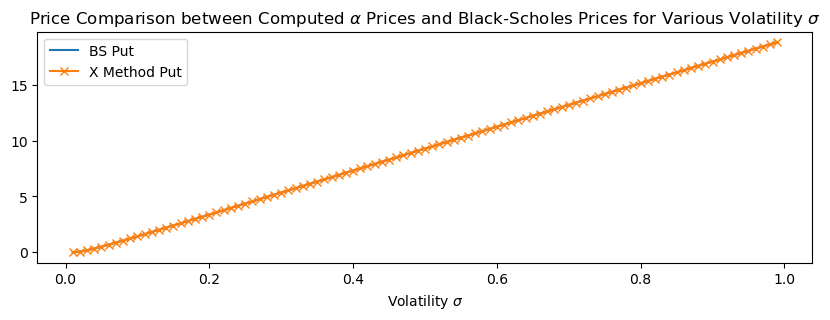

In [27]:
# Set the figure size
plt.figure(figsize=(10, 3))

plt.plot(tuned_prices_rg_p[r"$\sigma$"], bs_price_list["BS Put"], label="BS Put")
plt.plot(tuned_prices_rg_p[r"$\sigma$"], tuned_prices_rg_p["Put Price"], label="X Method Put", marker='x')

plt.xlabel(r"Volatility $\sigma$")
plt.ylabel("")
plt.title(r"Price Comparison between Computed $\alpha$ Prices and Black-Scholes Prices for Various Volatility $\sigma$")

plt.legend()

plt.show()

Thus, as we see from the plots above, the spline modeling of the functional forms of $\alpha$ as a function of volatilities $\sigma$ yields a useful accuracy for price matching for both call and put options.

## Exploring with finer volatilities

First, we compute the Black-Sholes values for finer volatilities.

In [28]:
finer_sigma = [0.01+0.0025*n for n in range(0, 397)]
finer_sigma[-1]

1.0

In [29]:
bs_price_list = []
for vol in finer_sigma:
    call = bs_pricing(S_ini, K, T, rf, vol, 0, 'c')
    put = bs_pricing(S_ini, K, T, rf, vol, 0, 'p')
    bs_price_list.append({
        r"$\sigma$": float(vol),
        "BS Call": call,
        "BS Put": put
    })

bs_price_list = pd.DataFrame(bs_price_list)

In [30]:
bs_price_list.T

,0,1,2,3,4,5,6,7,8,9,...,387,388,389,390,391,392,393,394,395,396
$\sigma$,0.010000,0.012500,0.015000,0.017500,0.020000,0.022500,0.025000,0.027500,0.030000,0.032500,...,0.977500,0.980000,0.982500,0.985000,0.987500,0.990000,0.992500,0.995000,0.997500,1.000000
BS Call,1.243216,1.247494,1.256997,1.272151,1.292491,1.317265,1.345714,1.377179,1.411116,1.447086,...,19.813309,19.861389,19.909461,19.957527,20.005585,20.053635,20.101678,20.149714,20.197743,20.245764
BS Put,0.000996,0.005274,0.014777,0.029931,0.050271,0.075045,0.103494,0.134959,0.168896,0.204866,...,18.571089,18.619169,18.667241,18.715307,18.763365,18.811415,18.859459,18.907494,18.955523,19.003544


In [31]:
binomial_price_list = []
for vol in finer_sigma:
    bin_call = binomial_call_full(S_ini, K, T, rf, vol, M)[0]
    bin_put = binomial_put_full(S_ini, K, T, rf, vol, M)[0]
    binomial_price_list.append({
        r"$\sigma$": vol,
        "Binomial Call": bin_call,
        "Binomial Put": bin_put
    })

binomial_price_list = pd.DataFrame(binomial_price_list)

In [32]:
binomial_price_list.T

,0,1,2,3,4,5,6,7,8,9,...,387,388,389,390,391,392,393,394,395,396
$\sigma$,0.010000,0.012500,0.015000,0.017500,0.020000,0.022500,0.025000,0.027500,0.030000,0.032500,...,0.977500,0.980000,0.982500,0.985000,0.987500,0.990000,0.992500,0.995000,0.99750,1.000000
Binomial Call,1.242971,1.246814,1.255845,1.270578,1.290562,1.315033,1.343216,1.374442,1.408156,1.443915,...,19.733532,19.781413,19.829285,19.877151,19.925009,19.972861,20.020704,20.068541,20.11637,20.164191
Binomial Put,0.000751,0.004594,0.013625,0.028358,0.048342,0.072813,0.100996,0.132222,0.165936,0.201695,...,18.491312,18.539193,18.587066,18.634931,18.682790,18.730641,18.778484,18.826321,18.87415,18.921972


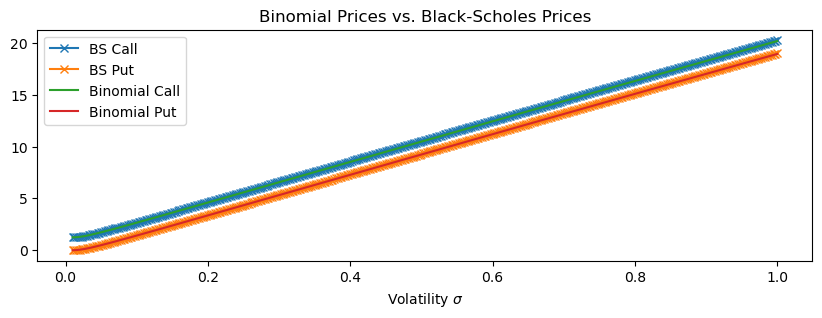

In [33]:
# Set the figure size
plt.figure(figsize=(10, 3))

plt.plot(bs_price_list[r"$\sigma$"], bs_price_list["BS Call"], label="BS Call", marker="x")
plt.plot(bs_price_list[r"$\sigma$"], bs_price_list["BS Put"], label="BS Put", marker="x")
plt.plot(bs_price_list[r"$\sigma$"], binomial_price_list["Binomial Call"], label="Binomial Call")
plt.plot(bs_price_list[r"$\sigma$"], binomial_price_list["Binomial Put"], label="Binomial Put")

plt.xlabel(r"Volatility $\sigma$")
plt.ylabel("")
plt.title("Binomial Prices vs. Black-Scholes Prices")

plt.legend()

plt.show()

In [34]:
price_dist_coll = []
for vol in finer_sigma:
    price_dist = []
    for r in range(0, M+1):
        dt = T/M
        u = np.exp(vol * np.sqrt(dt))
        d = 1/u
        p = (np.exp(rf * dt) - d) / (u - d)
        q = 1-p
        price = float(S_ini*(u**r)*(d**(M-r)))
        freq = math.comb(M, r)
        price_dist.append({
            "r": int(r),
            "End Price": price,
            "Frequency": freq
        })
    price_dist = pd.DataFrame(price_dist)
    price_dist_coll = price_dist_coll+[price_dist]

In [35]:
def kernel(alpha, x, M):
    return (alpha-2)*abs((8.2*x/M)-4.1)+0.9
    ## We compute for the values of alpha+1 instead because the factor itself approachs 0, making computation very sensitive and inaccurate

def erf_c(alpha):
        df = price_dist_coll[n]
        df["Adjusted Freq."] = df["Frequency"]*(kernel(alpha, df["r"], 60))
        terms_c = []
        for r in range(0, M+1):
            term_c = (max(df['End Price'][r]-K, 0))*(df['Adjusted Freq.'][r])
            terms_c = terms_c+[term_c]
        sum_mod_price_c = sum(terms_c)
        call_price = np.exp(-rf*T)*(sum_mod_price_c/2**M)
        bs_call_price = (bs_price_list.loc[bs_price_list[r"$\sigma$"] == finer_sigma[n], "BS Call"]).iloc[0] #This is the Black-Scholes call price that has been computed above.
        return float(abs(call_price-bs_call_price))

def erf_p(alpha):
        df = price_dist_coll[n]
        df["Adjusted Freq."] = df["Frequency"]*(kernel(alpha, df["r"], 60))
        terms_p = []
        for r in range(0, M+1):
            term_p = (max(K-df['End Price'][r], 0))*(df['Adjusted Freq.'][r])
            terms_p = terms_p+[term_p]
        sum_mod_price_p = sum(terms_p)
        put_price = np.exp(-rf*T)*(sum_mod_price_p/2**M)
        bs_put_price = (bs_price_list.loc[bs_price_list[r"$\sigma$"] == finer_sigma[n], "BS Put"]).iloc[0]
        return float(abs(put_price-bs_put_price))

In [36]:
pred_call_alphas = []
for n in range(0, 397):
    pred_alpha = spline_call(finer_sigma[n])
    pred_call_alphas.append({
        r"$\sigma$": finer_sigma[n],
        r"Pred. $\alpha$ (Call)": pred_alpha
    })

pred_call_alphas = pd.DataFrame(pred_call_alphas)
pred_call_alphas.T

,0,1,2,3,4,5,6,7,8,9,...,387,388,389,390,391,392,393,394,395,396
$\sigma$,0.01,0.0125,0.015,0.0175,0.02,0.0225,0.025,0.0275,0.03,0.0325,...,0.9775,0.98,0.9825,0.985,0.9875,0.99,0.9925,0.995,0.9975,1.0
Pred. $\alpha$ (Call),10.125535384906991,8.517463570092126,7.251289151013299,6.2801332837098585,5.557117124221169,5.035361828586578,4.667988552845438,4.408118453037105,4.208872685200932,4.031459087957049,...,1.7710494111212423,1.7699951762336101,1.7689424652850896,1.7678912651341836,1.7668415626393923,1.7657933446592184,1.7647465980521635,1.7637013096767298,1.7626574663914183,1.7616150550547305


In [37]:
tuned_prices_rg_c = []
for n in range(0, 397):
    df = price_dist_coll[n]
    df["Adjusted Freq. C"] = df["Frequency"]*(kernel((pred_call_alphas.loc[pred_call_alphas[r"$\sigma$"]==finer_sigma[n], r"Pred. $\alpha$ (Call)"]).iloc[0], df["r"], 60))
    terms_c = []
    for r in range(0, M+1):
        term_c = (max(df['End Price'][r]-K, 0))*(df['Adjusted Freq. C'][r])
        terms_c = terms_c+[term_c]
    sum_mod_price_c = sum(terms_c)
    call_price = np.exp(-rf*T)*(sum_mod_price_c/2**M)
    bs_call_price = (bs_price_list.loc[bs_price_list[r"$\sigma$"] == finer_sigma[n], "BS Call"]).iloc[0]
    
    tuned_prices_rg_c.append({
        r"$\sigma$": finer_sigma[n],
        "Call Price": float(call_price),
        "BS Call": float(bs_price_list.loc[bs_price_list[r"$\sigma$"] == finer_sigma[n], "BS Call"].iloc[0]),
        "Diff. (Call)": float(abs(call_price-bs_call_price))
    })

tuned_prices_rg_c = pd.DataFrame(tuned_prices_rg_c)
tuned_prices_rg_c.T

,0,1,2,3,4,5,6,7,8,9,...,387,388,389,390,391,392,393,394,395,396
$\sigma$,1.000000e-02,0.012500,0.015000,0.017500,2.000000e-02,0.022500,0.025000,0.027500,3.000000e-02,0.032500,...,9.775000e-01,9.800000e-01,9.825000e-01,0.985000,0.987500,0.990000,0.992500,0.995000,0.997500,1.000000
Call Price,1.243216e+00,1.291528,1.301636,1.296373,1.292491e+00,1.300625,1.325265,1.364726,1.411116e+00,1.453784,...,1.981331e+01,1.986139e+01,1.990946e+01,19.957525,20.005581,20.053628,20.101666,20.149696,20.197717,20.245728
BS Call,1.243216e+00,1.247494,1.256997,1.272151,1.292491e+00,1.317265,1.345714,1.377179,1.411116e+00,1.447086,...,1.981331e+01,1.986139e+01,1.990946e+01,19.957527,20.005585,20.053635,20.101678,20.149714,20.197743,20.245764
Diff. (Call),2.743221e-07,0.044034,0.044638,0.024223,9.816528e-08,0.016640,0.020449,0.012453,9.223545e-08,0.006698,...,6.611387e-07,4.889602e-07,2.150120e-07,0.000002,0.000004,0.000007,0.000012,0.000018,0.000026,0.000036


A glace at the table reveals that for interpolated values of $\alpha$, the difference in prices is quite pronounced for low volatility values (corresponding to near-zero values of those call options), whereas the difference is less significant for volatility values closer to unity (corresponding to higher call prices), albeit still quite noticeable. Despite that, notice that the pronounced differences only occur within the interval where interpolation takes place, which suggests that the finer we started off with the interpolating seed (the `sigma` or `finer_sigma`), the better.

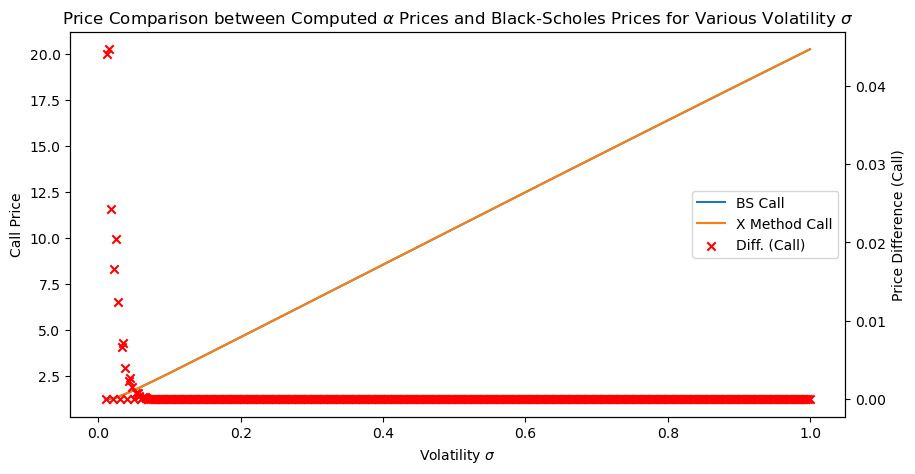

In [38]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the first set of data (BS Call and X Method Call)
ax1.plot(tuned_prices_rg_c[r"$\sigma$"], bs_price_list["BS Call"], label="BS Call")
ax1.plot(tuned_prices_rg_c[r"$\sigma$"], tuned_prices_rg_c["Call Price"], label="X Method Call")
ax1.set_xlabel(r"Volatility $\sigma$")
ax1.set_ylabel("Call Price") # Add y label for the first axis.

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
ax2.scatter(tuned_prices_rg_c[r"$\sigma$"], tuned_prices_rg_c["Diff. (Call)"], color='red', marker='x', label="Diff. (Call)")
ax2.set_ylabel("Price Difference (Call)") # Set y label for the second axis

# Set title and legend
plt.title(r"Price Comparison between Computed $\alpha$ Prices and Black-Scholes Prices for Various Volatility $\sigma$")

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right')

# Save the plot as a JPG file
plt.savefig('call_comparison.jpg', dpi=350, bbox_inches='tight') #Adjust dpi as needed.

# Show the plot
plt.show()

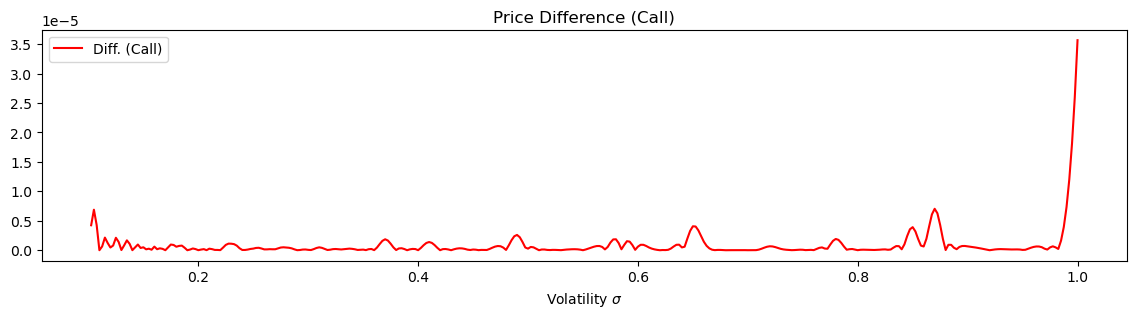

In [39]:
plt.figure(figsize=(14, 3))

truncated_c = tuned_prices_rg_c[tuned_prices_rg_c[r"$\sigma$"] > 0.1]
plt.plot(truncated_c[r"$\sigma$"], truncated_c["Diff. (Call)"], color='red', label="Diff. (Call)")

plt.xlabel(r"Volatility $\sigma$")
plt.ylabel("")
plt.title("Price Difference (Call)")

plt.legend()

plt.show()

The plot clearly shows the close adherence to Black-Scholes just as $\sigma$ moves out of the $[0, 0.1]$ interval. We repeat similar analysis and plotting for put options.

In [40]:
pred_put_alphas = []
for n in range(0, 397):
    pred_alpha = spline_put(finer_sigma[n])
    pred_put_alphas.append({
        r"$\sigma$": finer_sigma[n],
        r"Pred. $\alpha$ (Put)": pred_alpha
    })

pred_put_alphas = pd.DataFrame(pred_put_alphas)
pred_put_alphas.T

,0,1,2,3,4,5,6,7,8,9,...,387,388,389,390,391,392,393,394,395,396
$\sigma$,0.01,0.0125,0.015,0.0175,0.02,0.0225,0.025,0.0275,0.03,0.0325,...,0.9775,0.98,0.9825,0.985,0.9875,0.99,0.9925,0.995,0.9975,1.0
Pred. $\alpha$ (Put),0.6555052636591847,0.6889992070655301,0.7324523784861171,0.7837087781018113,0.8406124060934795,0.9010072626419873,0.9627373479282005,1.0236466621329856,1.0815792054372084,1.1348407370138573,...,2.611283040762718,2.6127738986562794,2.614264304900124,2.615754261597642,2.6172437708522214,2.618732834767251,2.6202214554461194,2.621709634992217,2.623197375508931,2.6246846790996505


In [41]:
tuned_prices_rg_p = []
for n in range(0, 397):
    df = price_dist_coll[n]
    df["Adjusted Freq. P"] = df["Frequency"]*(kernel((pred_put_alphas.loc[pred_put_alphas[r"$\sigma$"]==finer_sigma[n], r"Pred. $\alpha$ (Put)"]).iloc[0], df["r"], 60))
    terms_p = []
    for r in range(0, M+1):
        term_p = (max(K-df['End Price'][r], 0))*(df['Adjusted Freq. P'][r])
        terms_p = terms_p+[term_p]
    sum_mod_price_p = sum(terms_p)
    put_price = np.exp(-rf*T)*(sum_mod_price_p/2**M)
    bs_put_price = (bs_price_list.loc[bs_price_list[r"$\sigma$"] == finer_sigma[n], "BS Put"]).iloc[0]
    
    tuned_prices_rg_p.append({
        r"$\sigma$": finer_sigma[n],
        "Put Price": float(put_price),
        "BS Put": float(bs_price_list.loc[bs_price_list[r"$\sigma$"] == finer_sigma[n], "BS Put"].iloc[0]),
        "Diff. (Put)": float(abs(put_price-bs_put_price))
    })

tuned_prices_rg_p = pd.DataFrame(tuned_prices_rg_p)
tuned_prices_rg_p.T

,0,1,2,3,4,5,6,7,8,9,...,387,388,389,390,391,392,393,394,395,396
$\sigma$,1.000000e-02,0.012500,0.015000,0.017500,2.000000e-02,0.022500,0.025000,0.027500,3.000000e-02,0.032500,...,9.775000e-01,9.800000e-01,9.825000e-01,9.850000e-01,9.875000e-01,0.990000,0.992500,0.995000,0.997500,1.000000
Put Price,9.958234e-04,0.006733,0.016593,0.031044,5.027125e-02,0.074181,0.102401,0.134281,1.688956e-01,0.205238,...,1.857109e+01,1.861917e+01,1.866724e+01,1.871531e+01,1.876336e+01,18.811414,18.859457,18.907492,18.955519,19.003539
BS Put,9.958226e-04,0.005274,0.014777,0.029931,5.027126e-02,0.075045,0.103494,0.134959,1.688956e-01,0.204866,...,1.857109e+01,1.861917e+01,1.866724e+01,1.871531e+01,1.876336e+01,18.811415,18.859459,18.907494,18.955523,19.003544
Diff. (Put),8.340875e-10,0.001460,0.001816,0.001113,3.515791e-09,0.000864,0.001093,0.000678,9.041795e-10,0.000373,...,1.025418e-07,9.620038e-11,1.738941e-07,4.322110e-07,7.880805e-07,0.000001,0.000002,0.000003,0.000003,0.000004


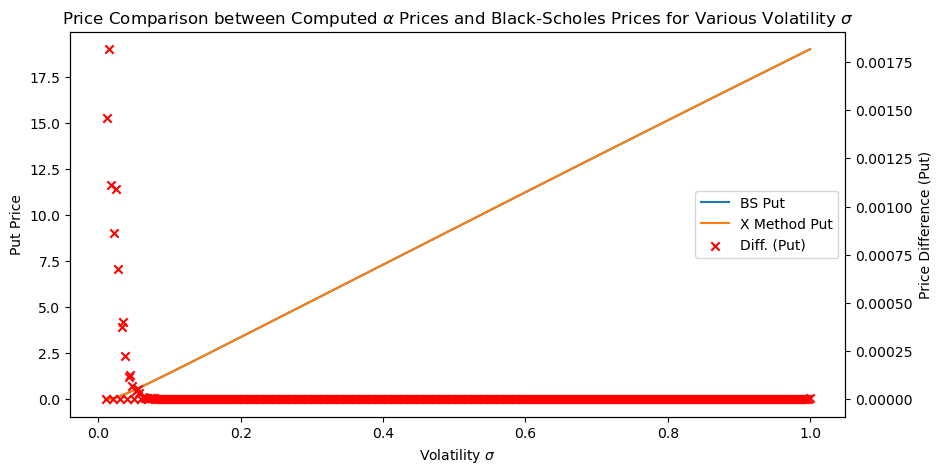

In [42]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the first set of data (BS Call and X Method Call)
ax1.plot(tuned_prices_rg_p[r"$\sigma$"], bs_price_list["BS Put"], label="BS Put")
ax1.plot(tuned_prices_rg_p[r"$\sigma$"], tuned_prices_rg_p["Put Price"], label="X Method Put")
ax1.set_xlabel(r"Volatility $\sigma$")
ax1.set_ylabel("Put Price") # Add y label for the first axis.

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
ax2.scatter(tuned_prices_rg_p[r"$\sigma$"], tuned_prices_rg_p["Diff. (Put)"], color='red', marker='x', label="Diff. (Put)")
ax2.set_ylabel("Price Difference (Put)") # Set y label for the second axis

# Set title and legend
plt.title(r"Price Comparison between Computed $\alpha$ Prices and Black-Scholes Prices for Various Volatility $\sigma$")

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right')

# Save the plot as a JPG file
plt.savefig('put_comparison.jpg', dpi=350, bbox_inches='tight') #Adjust dpi as needed.

# Show the plot
plt.show()

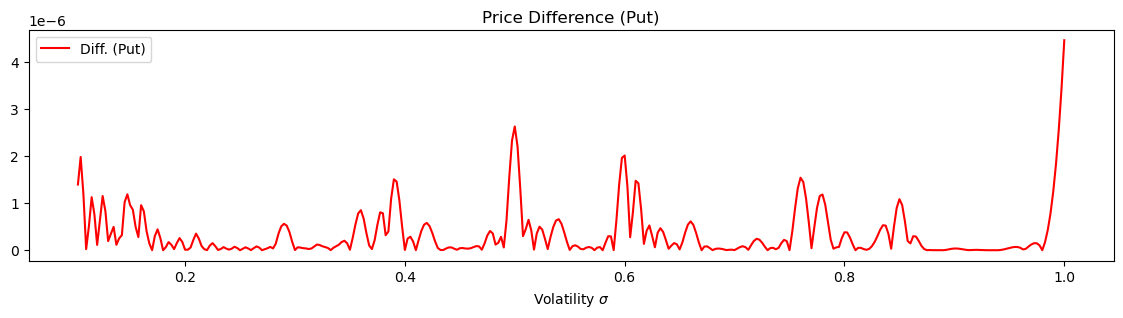

In [43]:
plt.figure(figsize=(14, 3))

truncated_p = tuned_prices_rg_p[tuned_prices_rg_c[r"$\sigma$"] > 0.1]
plt.plot(truncated_p[r"$\sigma$"], truncated_p["Diff. (Put)"], color='red', label="Diff. (Put)")

plt.xlabel(r"Volatility $\sigma$")
plt.ylabel("")
plt.title("Price Difference (Put)")

plt.legend()

plt.show()

The conclusion is the same as that for call options: the plot clearly shows the close adherence to Black-Scholes just as $\sigma$ moves out of the $[0, 0.1]$ interval.

## Conclusion

When we take the payoffs from a binomial tree and average them to obtain the prices of the option, the prices we obtain are meaningless. If one ponders about it, the "binomial distribution" has fairly thin tails, with frequency 1 at each tail tip. (The words "binomial distribution" are put in quotation marks because we are not looking at the probabilistic version per se, but the histogram version.) In this experimental work, we attempt to fatten the tails of a binomial distribution to match the Black-Scholes and Binomial Pricing Method prices. We modify the tail frequencies by reducing their proportion in the center and fattening them towards the tips in a linear fashion, the modifying kernel which is given by $K_\alpha(r) = \alpha\left(\left\lvert\frac{8.2r}{M}-4.1\right\rvert+0.9\right)$. (For stability of results though, we did shift the values of $\alpha$, but the essence of the idea remains the same.) Our task has been to reverse engineer the $\alpha$s from a series of volatility values $\sigma$, use the spline method to extract the approximate underlying functional form, one for each option type, and use these spline interpolations to derive other values of $\sigma$. We then use these interpolated values of $\alpha$ to derive the option prices and compare them with the corresponding Black-Scholes prices. The main results are shown in the two plots immediately above, which show the faitiful reliability for such a method to obtain option prices for various volatility values. The merit of this method as compared to the other numerical (non-Black-Scholes) methods is its slightly lower computational cost, and is easier to program. Namely, if compared to the Binomial Pricing Method proper, which has quadratic complexity ($M^2$), the X-Method is comparatively linear:

1. Fix a choiced $M$, the number of Bernoulli trials. For any volatility value $\sigma\in[0.1, 1]$, compute the $M+1$ end prices of the underlying asset as well as the frequencies, which are the binomial coefficients.
2. Use the spline function `spline_call` or `spline_put` to obtain the associated $\alpha$ value; call that value $\alpha^*$.
3. Plug $\alpha^*$ in to $K_\alpha(r)$ to modify the $M+1$ frequencies of the "binomial distribution" with $M$ Bernoulli trials.
4. Use the modified frequencies to obtained the weighted payoffs. Take the sum of these weighted payoffs and average them. Discount the average for the price of the option.

As we see, Steps 3 & 4 constitute the linear complexity in comparison to the full Binomial Pricing Method. The method here is linear in $M$ (or $M/2$ if one insists on using symmetry of the binomial distribution), while the full Binomial Pricing Method is quadratic in $M$, for when we consider the prices and discounting at each depth $r$ of the tree, a computation that involves $2(r-1)+2$ computations, adding all up yields:
\begin{equation}
\sum_{r=1}^M \big[2(r-1)+2\big] = \sum_{r=1}^M 2r = M(M+1).
\end{equation}
Of course, $\sigma$ is not limited to $[0.1, 1]$ and may be extended to greater values.

To summarize it all, the X Method is linear in $M$ while the full Binomial method is quadratic in $M$.

-By Benjamin Zu Yao Teoh. March 23, 2025.